<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Prophet_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.모듈 불러오기**








In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error

import pmdarima as pm 

import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **2.data**


In [5]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.30,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,"9,644.00",91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,"9,644.00",91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,"9,619.25",89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,"9,586.00",90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,93.50,85.72,67.83,"6,336.00",59.41,59.12,37.47,690.0,1.40115,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
3008,2019-03-28,92.95,85.64,67.82,"6,368.75",59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,92.75,85.70,68.39,"6,475.75",60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,92.75,85.70,68.39,"6,475.75",60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


# **3.Prophet model**
  -Basic

In [6]:
def prophetm(df, z, x, y) :
  
        #a = prophetm(z, x, y) 
        df1 = df[['date', z]]
      
    
        df1.columns = ['ds', 'y']
        df1['ds']= pd.to_datetime(df1['ds'])
        
      
        train = df1.drop(df.index[x:])
        y_true = df1['y'][y:].values 
        
      
        last_1year = pd.date_range('2019-01-01', periods=90)
        last_1year = list(last_1year)
        last_1year = pd.DataFrame(last_1year, columns = ['ds'])
        last_1year['ds']= pd.to_datetime(last_1year['ds'])
        m = Prophet(
        # trend
                changepoint_prior_scale=0.05,
        # seasonality
                weekly_seasonality=10,
                yearly_seasonality=20,
              daily_seasonality=False,)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        forecast = m.fit(train).predict(last_1year)
        # fig = m.plot_components(forecast)
        # a = add_changepoints_to_plot(fig.gca(), m, forecast)
        y_pred = forecast['yhat'].values
       
        return y_pred, last_1year['ds'], y_true
      
# z = str(input('컬럼명 입력(''제외 입력): '))
# x = int(input('삭제할 주 단위를 입력해주세요(-붙여서): '))
# y = int(input('필요한 y값의 월 단위를 입력해주세요(-붙여서): '))




# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


MAE: 12.312
MAPE: 0.128


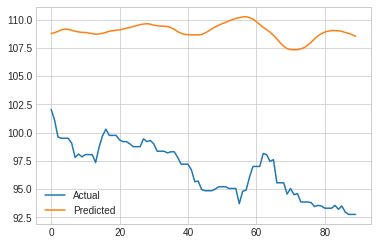

In [41]:
# # 함수에 적용과 데이터 프레임 만들어 값 넣어주기
# y_tt = prophetm(df, 'Coal_price', -12, -90)
# y_tt = pd.DataFrame(y_tt)
# y_tt = y_tt.T
# y_tr = y_tt[[1,2]]
# y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
# y_tt = y_tt[[1,0]]
# y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# # print(y_tt)
# # print(y_true)

# # 예측하고 비교하기
# # 여기에서는 MAE를 살펴본다.

# y_pred = y_tt['y_pred'].values
# y_true = y_tr['y_true'].values
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# mae = mean_absolute_error(y_true, y_pred)
# mape = mean_absolute_percentage_error(y_true, y_pred)

# print('MAE: %.3f' % mae)
# print('MAPE: %.3f' % mape)
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

#4.Prameter조정 prophet model

1.   Trend

*   **changepoints**	트렌드 변화시점을 명시한 리스트값
*  **changepoint_prior_scale**	changepoint(trend) 의 유연성 조절
*   **n_changepoints**	changepoint 의 개수
*   **changepoint_range**	changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


2.   **Seasonality**
*  **yearly_seasonality**	연 계절성
*  **weekly_seasonality**	주 계절성
*  **daily_seasonality**	일 계절성
*  **seasonality_prior_scale**	계절성 반영 강도
*  **seasonality_mode**	‘additive ‘ 인지 ‘multiplicative’ 인지


In [33]:
# def prophetm1(df, z, x, y) :
  
#         #a = prophetm(z, x, y) 
#         df1 = df[['date', z]]
      
    
#         df1.columns = ['ds', 'y']
#         df1['ds']= pd.to_datetime(df1['ds'])
        
      
#         train = df1.drop(df.index[x:])
#         y_true = df1['y'][y:].values 
        
      
#         last_1year = pd.date_range('2019-01-01', periods=90)
#         last_1year = list(last_1year)
#         last_1year = pd.DataFrame(last_1year, columns = ['ds'])
#         last_1year['ds']= pd.to_datetime(last_1year['ds'])
#         m = Prophet(growth='linear', #linear -> 추세를 말함
#         # Trend
#         changepoints=None, # CP가 발생하는 시점들의 list ['2012-01-01']
#         n_changepoints=25, # CP의 수
#         changepoint_range=0.8, # CP의 기존 데이터 수 대비 최대 비율
#         changepoint_prior_scale=0.5, # CP 추정 민감도로 높을수록 민감
#         # Seasonality
#         seasonality_mode='additive', # 계절성 모델: 'additive' or 'multiplicative'
#         seasonality_prior_scale=10.0, # 계절성 추정 민감도로 높을수록 민감
#         yearly_seasonality= True, # 연계절성
#         weekly_seasonality='auto', # 주계절성
#         daily_seasonality='auto', #일계절성
#         # Holiday
#         holidays=None, # 휴일 또는 이벤트 시점 dataframe
#         holidays_prior_scale=10.0, # 휴일 추정 민감도로 높을수록 민감
#         # Others
#         interval_width=0.8, # 추세 예측 정확도 구간범위
#         mcmc_samples=0) # 계절성 예측 정확도 제어
#         forecast = m.fit(train).predict(last_1year)
#         # fig = m.plot_components(forecast)
#         # a = add_changepoints_to_plot(fig.gca(), m, forecast)
#         y_pred = forecast['yhat'].values
       
#         return y_pred, last_1year['ds'], y_true
      
# # z = str(input('컬럼명 입력(''제외 입력): '))
# # x = int(input('삭제할 주 단위를 입력해주세요(-붙여서): '))
# # y = int(input('필요한 y값의 월 단위를 입력해주세요(-붙여서): '))




# # print('-------------done------------')
# # print('y_pred result: {} '  .format(y_pred))




INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 9.556
MAPE: 0.100


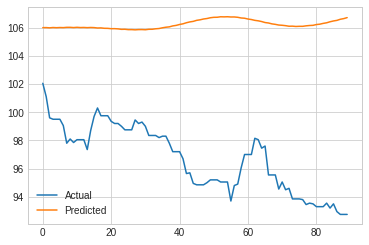

In [34]:
# # 함수에 적용과 데이터 프레임 만들어 값 넣어주기
# y_tt = prophetm1(df, 'Coal_price', -12, -90)
# y_tt = pd.DataFrame(y_tt)
# y_tt = y_tt.T
# y_true = y_tt[[1,2]]
# y_true = y_true.rename(columns ={2:'y_true',1:'ds'})
# y_tt = y_tt[[1,0]]
# y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# # print(y_tt)
# # print(y_true)

# # 예측하고 비교하기
# # 여기에서는 MAE를 살펴본다.

# y_pred = y_tt['y_pred'].values
# y_true = y_true['y_true'].values
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# mae = mean_absolute_error(y_true, y_pred)
# mape = mean_absolute_percentage_error(y_true, y_pred)

# print('MAE: %.3f' % mae)
# print('MAPE: %.3f' % mape)
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

# **Prophet model(bdi)**
  -bdi

In [7]:
def prophetm(df, z, x, y) :
  
        #a = prophetm(z, x, y) 
        df1 = df[['date', z]]
      
    
        df1.columns = ['ds', 'y']
        df1['ds']= pd.to_datetime(df1['ds'])
        
      
        train = df1.drop(df.index[x:])
        y_true = df1['y'][y:].values 
        
      
        last_1year = pd.date_range('2019-01-01', periods=90)
        last_1year = list(last_1year)
        last_1year = pd.DataFrame(last_1year, columns = ['ds'])
        last_1year['ds']= pd.to_datetime(last_1year['ds'])
        m = Prophet(
        # trend
                changepoint_prior_scale=0.05,
        # seasonality
                weekly_seasonality=10,
                yearly_seasonality=20,
              daily_seasonality=False,)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        forecast = m.fit(train).predict(last_1year)
        # fig = m.plot_components(forecast)
        # a = add_changepoints_to_plot(fig.gca(), m, forecast)
        y_pred = forecast['yhat'].values
       
        return y_pred, last_1year['ds'], y_true
      
# z = str(input('컬럼명 입력(''제외 입력): '))
# x = int(input('삭제할 주 단위를 입력해주세요(-붙여서): '))
# y = int(input('필요한 y값의 월 단위를 입력해주세요(-붙여서): '))




# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


MAE: 277.899
MAPE: 0.409


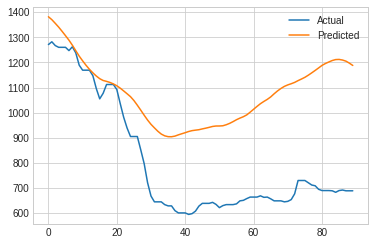

In [8]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'bdi', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [9]:
y_tr = y_tr.rename(columns ={'y_true':'bdi'})
y_tt = y_tt.rename(columns ={'y_pred':'bdi_pred'})

y_x = pd.merge(y_tt,y_tr)

In [10]:
y_x

,ds,bdi_pred,bdi
0,2019-01-01,1381.682968,1271.0
1,2019-01-02,1370.05157,1282.0
2,2019-01-03,1355.452987,1267.0
3,2019-01-04,1340.348076,1260.0
4,2019-01-05,1323.587394,1260.0
...,...,...,...
85,2019-03-27,1211.817052,690.0
86,2019-03-28,1209.393201,692.0
87,2019-03-29,1204.943404,689.0
88,2019-03-30,1197.049379,689.0


# **Prophet model(iron)**
  -iron   

MAE: 6.199
MAPE: 0.073


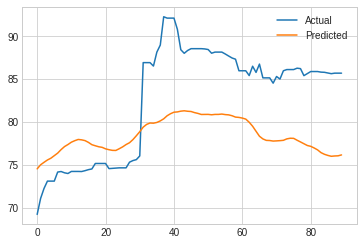

In [11]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'iron', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [12]:
y_tr = y_tr.rename(columns ={'y_true':'iron'})
y_tt = y_tt.rename(columns ={'y_pred':'iron_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)

In [13]:
y_x

,ds,bdi_pred,bdi,iron_pred,iron
0,2019-01-01,1381.682968,1271.0,74.522855,69.2
1,2019-01-02,1370.05157,1282.0,74.9963,71.06
2,2019-01-03,1355.452987,1267.0,75.284607,72.23
3,2019-01-04,1340.348076,1260.0,75.557884,73.09
4,2019-01-05,1323.587394,1260.0,75.76275,73.09
...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72
86,2019-03-28,1209.393201,692.0,75.990897,85.64
87,2019-03-29,1204.943404,689.0,76.026761,85.7
88,2019-03-30,1197.049379,689.0,76.046196,85.7


# **Prophet model(Brent_fut)**
  -Brent_fut   

MAE: 8.595
MAPE: 0.136


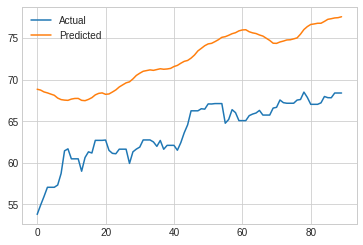

In [15]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'Brent_fut', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [16]:
y_tr = y_tr.rename(columns ={'y_true':'Brent_fut'})
y_tt = y_tt.rename(columns ={'y_pred':'Brent_fut_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06
...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39


# **Prophet model(LNG_fut)-b**
  -LNG_fut     

MAE: 13.098
MAPE: 0.313


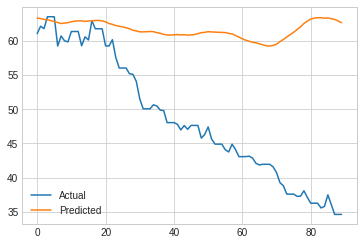

In [84]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'LNG_fut', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [85]:
y_tr = y_tr.rename(columns ={'y_true':'LNG_fut'})
y_tt = y_tt.rename(columns ={'y_pred':'LNG_fut_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,LNG_fut_pred,LNG_fut
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,63.360254,61.07
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,63.276945,62.16
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,63.160457,61.81
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,63.102454,63.55
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,62.989985,63.55
...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,63.369587,37.47
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,63.269052,36.05
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,63.153897,34.61
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,62.94107,34.61


# **Prophet model(USD/AUD(호주)**
  -USD/AUD(호주)  

MAE: 0.012
MAPE: 0.009


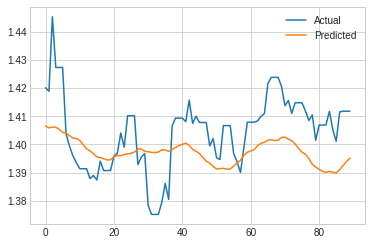

In [17]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'USD/AUD(호주)', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [18]:
y_tr = y_tr.rename(columns ={'y_true':'USD/AUD(호주)'})
y_tt = y_tt.rename(columns ={'y_pred':'USD/AUD(호주)_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,USD/AUD(호주)_pred,USD/AUD(호주)
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,1.406568,1.4201
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,1.405883,1.41886
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,1.406183,1.4453
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,1.406122,1.4273
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,1.405342,1.4273
...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,1.389891,1.40115
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,1.391029,1.41153
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,1.392517,1.4118
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,1.393901,1.4118


# **Prophet model(독일지수)b**
  - 독일지수 

MAE: 311.115
MAPE: 0.028


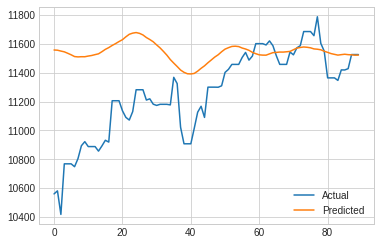

In [88]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, '독일지수', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [90]:
y_tr = y_tr.rename(columns ={'y_true':'독일지수'})
y_tt = y_tt.rename(columns ={'y_pred':'독일지수_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,LNG_fut_pred,LNG_fut,USD/AUD(호주)_pred,USD/AUD(호주),독일지수_pred,독일지수
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,63.360254,61.07,1.406568,1.4201,11557.656351,10558.959961
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,63.276945,62.16,1.405883,1.41886,11556.278493,10580.19043
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,63.160457,61.81,1.406183,1.4453,11550.236164,10416.660156
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,63.102454,63.55,1.406122,1.4273,11544.945422,10767.69043
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,62.989985,63.55,1.405342,1.4273,11534.936465,10767.69043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,63.369587,37.47,1.389891,1.40115,11528.228283,11419.040039
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,63.269052,36.05,1.391029,1.41153,11525.264561,11428.160156
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,63.153897,34.61,1.392517,1.4118,11524.243394,11526.040039
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,62.94107,34.61,1.393901,1.4118,11521.665939,11526.040039


# **Prophet model(S&P500지수)-soso**
  - S&P500지수

MAE: 83.389
MAPE: 0.032


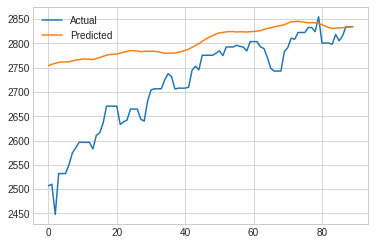

In [91]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, 'S&P500지수', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [92]:
y_tr = y_tr.rename(columns ={'y_true':'S&P500지수'})
y_tt = y_tt.rename(columns ={'y_pred':'S&P500지수_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,LNG_fut_pred,LNG_fut,USD/AUD(호주)_pred,USD/AUD(호주),독일지수_pred,독일지수,S&P500지수_pred,S&P500지수
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,63.360254,61.07,1.406568,1.4201,11557.656351,10558.959961,2754.210415,2506.850098
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,63.276945,62.16,1.405883,1.41886,11556.278493,10580.19043,2757.034104,2510.030029
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,63.160457,61.81,1.406183,1.4453,11550.236164,10416.660156,2758.962358,2447.889893
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,63.102454,63.55,1.406122,1.4273,11544.945422,10767.69043,2760.990116,2531.939941
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,62.989985,63.55,1.405342,1.4273,11534.936465,10767.69043,2761.586497,2531.939941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,63.369587,37.47,1.389891,1.40115,11528.228283,11419.040039,2831.970496,2805.370117
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,63.269052,36.05,1.391029,1.41153,11525.264561,11428.160156,2832.143058,2815.439941
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,63.153897,34.61,1.392517,1.4118,11524.243394,11526.040039,2833.015373,2834.399902
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,62.94107,34.61,1.393901,1.4118,11521.665939,11526.040039,2833.316948,2834.399902


# **Prophet model(니케이225지수)soso**
  -니케이225지수

MAE: 1241.646
MAPE: 0.060


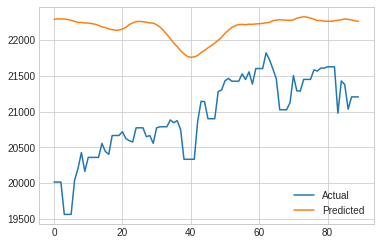

In [93]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, '니케이225지수', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [94]:
y_tr = y_tr.rename(columns ={'y_true':'니케이225지수'})
y_tt = y_tt.rename(columns ={'y_pred':'니케이225지수_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,LNG_fut_pred,LNG_fut,USD/AUD(호주)_pred,USD/AUD(호주),독일지수_pred,독일지수,S&P500지수_pred,S&P500지수,니케이225지수_pred,니케이225지수
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,63.360254,61.07,1.406568,1.4201,11557.656351,10558.959961,2754.210415,2506.850098,22289.23744,20014.769531
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,63.276945,62.16,1.405883,1.41886,11556.278493,10580.19043,2757.034104,2510.030029,22298.740508,20014.769531
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,63.160457,61.81,1.406183,1.4453,11550.236164,10416.660156,2758.962358,2447.889893,22295.811253,20014.769531
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,63.102454,63.55,1.406122,1.4273,11544.945422,10767.69043,2760.990116,2531.939941,22295.969776,19561.960938
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,62.989985,63.55,1.405342,1.4273,11534.936465,10767.69043,2761.586497,2531.939941,22287.766273,19561.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,63.369587,37.47,1.389891,1.40115,11528.228283,11419.040039,2831.970496,2805.370117,22296.531669,21378.730469
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,63.269052,36.05,1.391029,1.41153,11525.264561,11428.160156,2832.143058,2815.439941,22289.778329,21033.759766
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,63.153897,34.61,1.392517,1.4118,11524.243394,11526.040039,2833.015373,2834.399902,22283.090047,21205.810547
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,62.94107,34.61,1.393901,1.4118,11521.665939,11526.040039,2833.316948,2834.399902,22270.834705,21205.810547


# **Prophet model(호주지수)**
  -호주지수

MAE: 101.842
MAPE: 0.017


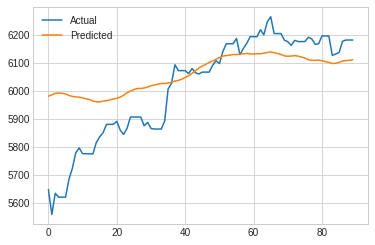

In [19]:
# 함수에 적용과 데이터 프레임 만들어 값 넣어주기
y_tt = prophetm(df, '호주지수', -12, -90)
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [20]:
y_tr = y_tr.rename(columns ={'y_true':'호주지수'})
y_tt = y_tt.rename(columns ={'y_pred':'호주지수_pred'})

y_x = pd.merge(y_x,y_tt)
y_x = pd.merge(y_x,y_tr)
y_x

,ds,bdi_pred,bdi,iron_pred,iron,Brent_fut_pred,Brent_fut,USD/AUD(호주)_pred,USD/AUD(호주),호주지수_pred,호주지수
0,2019-01-01,1381.682968,1271.0,74.522855,69.2,68.844687,53.8,1.406568,1.4201,5980.200692,5646.399902
1,2019-01-02,1370.05157,1282.0,74.9963,71.06,68.743551,54.91,1.405883,1.41886,5984.851004,5557.799805
2,2019-01-03,1355.452987,1267.0,75.284607,72.23,68.520474,55.95,1.406183,1.4453,5990.306901,5633.399902
3,2019-01-04,1340.348076,1260.0,75.557884,73.09,68.405736,57.06,1.406122,1.4273,5991.308905,5619.399902
4,2019-01-05,1323.587394,1260.0,75.76275,73.09,68.257358,57.06,1.405342,1.4273,5990.534668,5619.399902
...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,1211.817052,690.0,76.092352,85.72,77.246685,67.83,1.389891,1.40115,6100.838035,6136.0
86,2019-03-28,1209.393201,692.0,75.990897,85.64,77.320475,67.82,1.391029,1.41153,6105.757931,6176.100098
87,2019-03-29,1204.943404,689.0,76.026761,85.7,77.411569,68.39,1.392517,1.4118,6107.270158,6180.700195
88,2019-03-30,1197.049379,689.0,76.046196,85.7,77.445115,68.39,1.393901,1.4118,6108.451123,6180.700195


In [97]:
y_x.to_csv('/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred.csv', index = False, encoding = 'utf-8-sig')

In [21]:
y_x.columns

Index(['ds', 'bdi_pred', 'bdi', 'iron_pred', 'iron', 'Brent_fut_pred',
       'Brent_fut', 'USD/AUD(호주)_pred', 'USD/AUD(호주)', '호주지수_pred', '호주지수'],
      dtype='object')

In [23]:
y_p = y_x[['ds', 'bdi_pred', 'iron_pred', 'Brent_fut_pred',
        'USD/AUD(호주)_pred',  '호주지수_pred']]
y_p

,ds,bdi_pred,iron_pred,Brent_fut_pred,USD/AUD(호주)_pred,호주지수_pred
0,2019-01-01,1381.682968,74.522855,68.844687,1.406568,5980.200692
1,2019-01-02,1370.05157,74.9963,68.743551,1.405883,5984.851004
2,2019-01-03,1355.452987,75.284607,68.520474,1.406183,5990.306901
3,2019-01-04,1340.348076,75.557884,68.405736,1.406122,5991.308905
4,2019-01-05,1323.587394,75.76275,68.257358,1.405342,5990.534668
...,...,...,...,...,...,...
85,2019-03-27,1211.817052,76.092352,77.246685,1.389891,6100.838035
86,2019-03-28,1209.393201,75.990897,77.320475,1.391029,6105.757931
87,2019-03-29,1204.943404,76.026761,77.411569,1.392517,6107.270158
88,2019-03-30,1197.049379,76.046196,77.445115,1.393901,6108.451123


In [24]:
y_p = y_p.rename(columns ={'bdi_pred':'bdi',
                       'iron_pred':'iron',
                       'Brent_fut_pred':'Brent_fut',
                      #  'LNG_fut_pred':'LNG_fut',
                       'USD/AUD(호주)_pred':'USD/AUD(호주)',
                      #  '독일지수_pred':'독일지수',
                      #  'S&P500지수_pred':'S&P500지수',
                      #  '니케이225지수_pred':'니케이225지수',
                       '호주지수_pred':'호주지수',
                       })

y_p

,ds,bdi,iron,Brent_fut,USD/AUD(호주),호주지수
0,2019-01-01,1381.682968,74.522855,68.844687,1.406568,5980.200692
1,2019-01-02,1370.05157,74.9963,68.743551,1.405883,5984.851004
2,2019-01-03,1355.452987,75.284607,68.520474,1.406183,5990.306901
3,2019-01-04,1340.348076,75.557884,68.405736,1.406122,5991.308905
4,2019-01-05,1323.587394,75.76275,68.257358,1.405342,5990.534668
...,...,...,...,...,...,...
85,2019-03-27,1211.817052,76.092352,77.246685,1.389891,6100.838035
86,2019-03-28,1209.393201,75.990897,77.320475,1.391029,6105.757931
87,2019-03-29,1204.943404,76.026761,77.411569,1.392517,6107.270158
88,2019-03-30,1197.049379,76.046196,77.445115,1.393901,6108.451123


In [25]:
y_p.to_csv('/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred_only.csv', index = False, encoding = 'utf-8-sig')